In [ ]:
!pip install patchify
!pip install segmentation_models

In [1]:
import numpy as np
from patchify import patchify
from PIL import Image

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import cv2
import segmentation_models as sm
import matplotlib.pyplot as plt
import random
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from google.colab import drive 

In [2]:
root_dir = 'Semantic segmentation dataset/'

so now we're going write a code that takes 256 x 256 image patches from the original images.
first of all we crop the images into a size where 256 x 256 patches can be extracted with little or no overlapping

In [3]:
patch_size = 256

def make_dataset():
    img_dataset = [] # a list to store all the extracted image patches
    mask_dataset = [] # a list to store all the extracted mask_patches
    for path, subdirs, files in os.walk(root_dir):
        
        dirname = path.split(os.path.sep)[-1]
        if dirname == 'images':
            print(path)
            for i, image_name in enumerate(files):
                image = cv2.imread(f'{path}/{image_name}')
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                size_w = (image.shape[1] // patch_size)*patch_size
                size_h = (image.shape[0] // patch_size)*patch_size
                image = Image.fromarray(image)
                image = image.crop((0, 0, size_w, size_h))
                image = np.array(image)

                print('Patching image..')
                img_patches = patchify(image, (patch_size, patch_size, 3), step=patch_size)
                for i in range(img_patches.shape[0]):
                    for j in range(img_patches.shape[1]):
                        single_patch = img_patches[i, j, :, :]

                        # normalizing
                        single_patch = single_patch / 255.0
                        img_dataset.append(single_patch[0]) # append with the extra axis dropped 

        elif dirname == 'masks':
            print(path)
            for i, image_name in enumerate(files):
                image = cv2.imread(f'{path}/{image_name}')
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                size_w = (image.shape[1] // patch_size)*patch_size
                size_h = (image.shape[0] // patch_size)*patch_size
                image = Image.fromarray(image)
                image = image.crop((0, 0, size_w, size_h))
                image = np.array(image)

                print('Patching masks..')
                img_patches = patchify(image, (patch_size, patch_size, 3), step=patch_size)
                for i in range(img_patches.shape[0]):
                    for j in range(img_patches.shape[1]):
                        single_patch = img_patches[i, j, :, :]

                        # normalizing
                        #single_patch = single_patch / 255.0
                        mask_dataset.append(single_patch[0]) # append with the extra axis dropped
    return np.array(img_dataset), np.array(mask_dataset)

In [4]:
image_array, mask_array = make_dataset()

Semantic segmentation dataset/Tile 1\images
Patching image..
Patching image..
Patching image..
Patching image..
Patching image..
Patching image..
Patching image..
Patching image..
Patching image..
Semantic segmentation dataset/Tile 1\masks
Patching masks..
Patching masks..
Patching masks..
Patching masks..
Patching masks..
Patching masks..
Patching masks..
Patching masks..
Patching masks..
Semantic segmentation dataset/Tile 2\images
Patching image..
Patching image..
Patching image..
Patching image..
Patching image..
Patching image..
Patching image..
Patching image..
Patching image..
Semantic segmentation dataset/Tile 2\masks
Patching masks..
Patching masks..
Patching masks..
Patching masks..
Patching masks..
Patching masks..
Patching masks..
Patching masks..
Patching masks..
Semantic segmentation dataset/Tile 3\images
Patching image..
Patching image..
Patching image..
Patching image..
Patching image..
Patching image..
Patching image..
Patching image..
Patching image..
Semantic segmenta

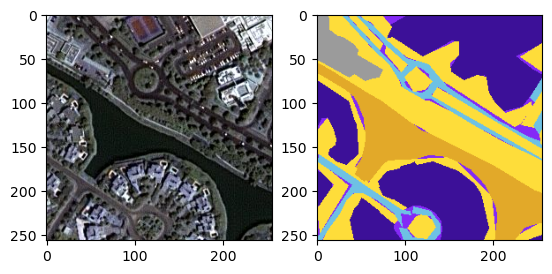

In [9]:
rand_number = random.randint(0, 1300)


plt.subplot(121)
plt.imshow(image_array[rand_number])
plt.subplot(122)
plt.imshow(mask_array[rand_number])

The labels(masks) are labeled pixel-wise due to the task at hand
The labels are in hexadecimal form  which will be converted to RGB


Labels include;

Building: '#3C1098'

Land: '#8429F6'

Road: '#6EC1E4'

Vegetation: '#FEDD3A'

Water: '#E2A929'

Unlabeled: '#9B9B9B'

In [10]:
mask_array[0]

array([[[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       ...,

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]]

In [11]:
building = '#3C1098'.strip('#')
building = np.array(tuple(int(building[i:i+2], 16) for i in [0, 2, 4]))

land = '#8429F6'.strip('#')
land = np.array(tuple(int(land[i:i+2], 16) for i in [0, 2, 4]))

road = '#6EC1E4'.strip('#')
road = np.array(tuple(int(road[i:i+2], 16) for i in [0, 2, 4]))

vegetation = '#FEDD3A'.strip('#')
vegetation = np.array(tuple(int(vegetation[i:i+2], 16) for i in [0, 2, 4]))

water = '#E2A929'.strip('#')
water = np.array(tuple(int(water[i:i+2], 16) for i in [0, 2, 4]))

unlabeled = '#9B9B9B'.strip('#')
unlabeled = np.array(tuple(int(unlabeled[i:i+2], 16) for i in [0, 2, 4]))

In [12]:
def rgb_to_2d(labels):
    label_segment = np.zeros(shape=labels.shape)
    label_segment[np.all(labels==building, axis=-1)] = 0
    label_segment[np.all(labels==land, axis=-1)] = 1
    label_segment[np.all(labels==road, axis=-1)] = 2
    label_segment[np.all(labels==vegetation, axis=-1)] = 3
    label_segment[np.all(labels==water, axis=-1)] = 4
    label_segment[np.all(labels==unlabeled, axis=-1)] = 5
    
    return label_segment[:, :, 0]


In [13]:
rgb_to_2d(mask_array[2])[0, 0]

4.0

In [14]:
labels = []
for i in range(mask_array.shape[0]):
    label = rgb_to_2d(mask_array[i])
    labels.append(label[..., np.newaxis])
labels = np.array(labels)
labels.shape

(1305, 256, 256, 1)

In [15]:
labels[0]

array([[[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]])

In [16]:
n_classes = 6

In [17]:
# convert the labels to one hot encoded form
labels = to_categorical(labels, num_classes=n_classes)

In [31]:
dataset = tf.data.Dataset.from_tensor_slices((image_array, labels))
split = len(dataset) * 0.2

val_ds = dataset.take(int(split)).batch(4)
train_ds = dataset.skip(int(split)).batch(4).prefetch(tf.data.AUTOTUNE)

# U-net Model

In [19]:
def conv_stack(filters, size, apply_dropout=True):
    initializer = 'he_normal'
    result = keras.Sequential()

    result.add(layers.Conv2D(filters, size, padding='same',
                                    kernel_initializer=initializer, activation='relu', use_bias=False))
  
    if apply_dropout:
        result.add(layers.Dropout(0.2))

    result.add(layers.Conv2D(filters, size, padding='same',
                                    kernel_initializer=initializer, activation='relu', use_bias=False))
    return result

In [93]:
'''def downsample(filters, size, apply_dropout=True, max_pooling=True):

    result = keras.Sequential()

    result.add(conv_stack(filters, size))
    
    if max_pooling:
        result.add(layers.MaxPooling2D(pool_size=(2, 2)))

    return result'''

In [94]:
'''test = downsample(16, 3)
test_result = test(tf.random.normal([1, 256, 256, 3]))
test.summary()'''

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (1, 256, 256, 16)         2736      
                                                                 
 max_pooling2d_3 (MaxPooling  (1, 128, 128, 16)        0         
 2D)                                                             
                                                                 
Total params: 2,736
Trainable params: 2,736
Non-trainable params: 0
_________________________________________________________________


In [20]:
def upsample(filters, size):
    
    result = keras.Sequential()
    result.add(
          layers.Conv2DTranspose(filters, size, strides=(2, 2),
                                    padding='same',
                                    use_bias=False))

    return result

In [89]:
'''uptest = upsample(128, 3)
upresult = uptest(test_result)
uptest.summary()'''

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_1 (Conv2DT  (1, 256, 256, 128)       18432     
 ranspose)                                                       
                                                                 
Total params: 18,432
Trainable params: 18,432
Non-trainable params: 0
_________________________________________________________________


In [21]:
def unet_model():
    inputs = keras.Input(shape=(256, 256, 3))
    
    c1 = conv_stack(16, 3)(inputs)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    c2 = conv_stack(32, 2)(p1)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    c3 = conv_stack(64, 3)(p2)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    c4 = conv_stack(128, 3)(p3)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    c5 = conv_stack(256, 3)(p4)
    
    up1 = upsample(128, 2)(c5)
    concat1 = layers.Concatenate()([up1, c4])
    conv1 = conv_stack(128, 3)(concat1)
    up2 = upsample(64, 2)(conv1)
    concat2 = layers.Concatenate()([up2, c3])
    conv2 = conv_stack(64, 3)(concat2)
    up3 = upsample(32, 2)(conv2)
    concat3 = layers.Concatenate()([up3, c2])
    conv3 = conv_stack(32, 3)(concat3)
    up4 = upsample(16, 2)(conv3)
    concat4 = layers.Concatenate()([up4, c1])
    conv4 = conv_stack(16, 3)(concat4)
    
    out = layers.Conv2D(6, (1, 1), padding='same', activation='softmax')(conv4)
    
    model = keras.Model(inputs=inputs, outputs=out)
    
    '''down_stack = [
        downsample(16, 3), # (batch_size, 128, 128, 16)
        downsample(32, 3), # (batch_size, 64, 64, 32)
        downsample(64, 3), # (batch_size, 32, 32, 64)
        downsample(128, 3), # (batch_size, 16, 16, 128)
        downsample(256, 3) # (batch_size, 8, 8, 256)
    ]
    
    up_stack = [
        upsample(128, 2), # (batch_size, 16, 16, 256)
        upsample(64, 2), # (batch_size, 32, 32, 128)
        upsample(32, 2), # (batch_size, 64, 64, 64)
        upsample(16, 2), # (batch_size, 128, 128, 32)
    ]
    
    conv_list = [
        conv_stack(128, 3),
        conv_stack(64, 3), 
        conv_stack(32, 3),
        conv_stack(16, 3)
    ]
    last = layers.Conv2DTranspose(n_classes, 1, strides=2, padding='same', activation='softmax', use_bias=False)
    
    x = inputs
    skips = []
    
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    
    for up, skip, conv in zip(up_stack, skips, conv_list):
        x = up(x)
        x = layers.Concatenate()([x, skip])
        x = conv(x)

    x = last(x)
    
    model = keras.Model(inputs = inputs, outputs=x)'''
    return model

In [32]:
model = unet_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_26 (Sequential)     (None, 256, 256, 16  2736        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 128, 128, 16  0          ['sequential_26[0][0]']          
                                )                                                           

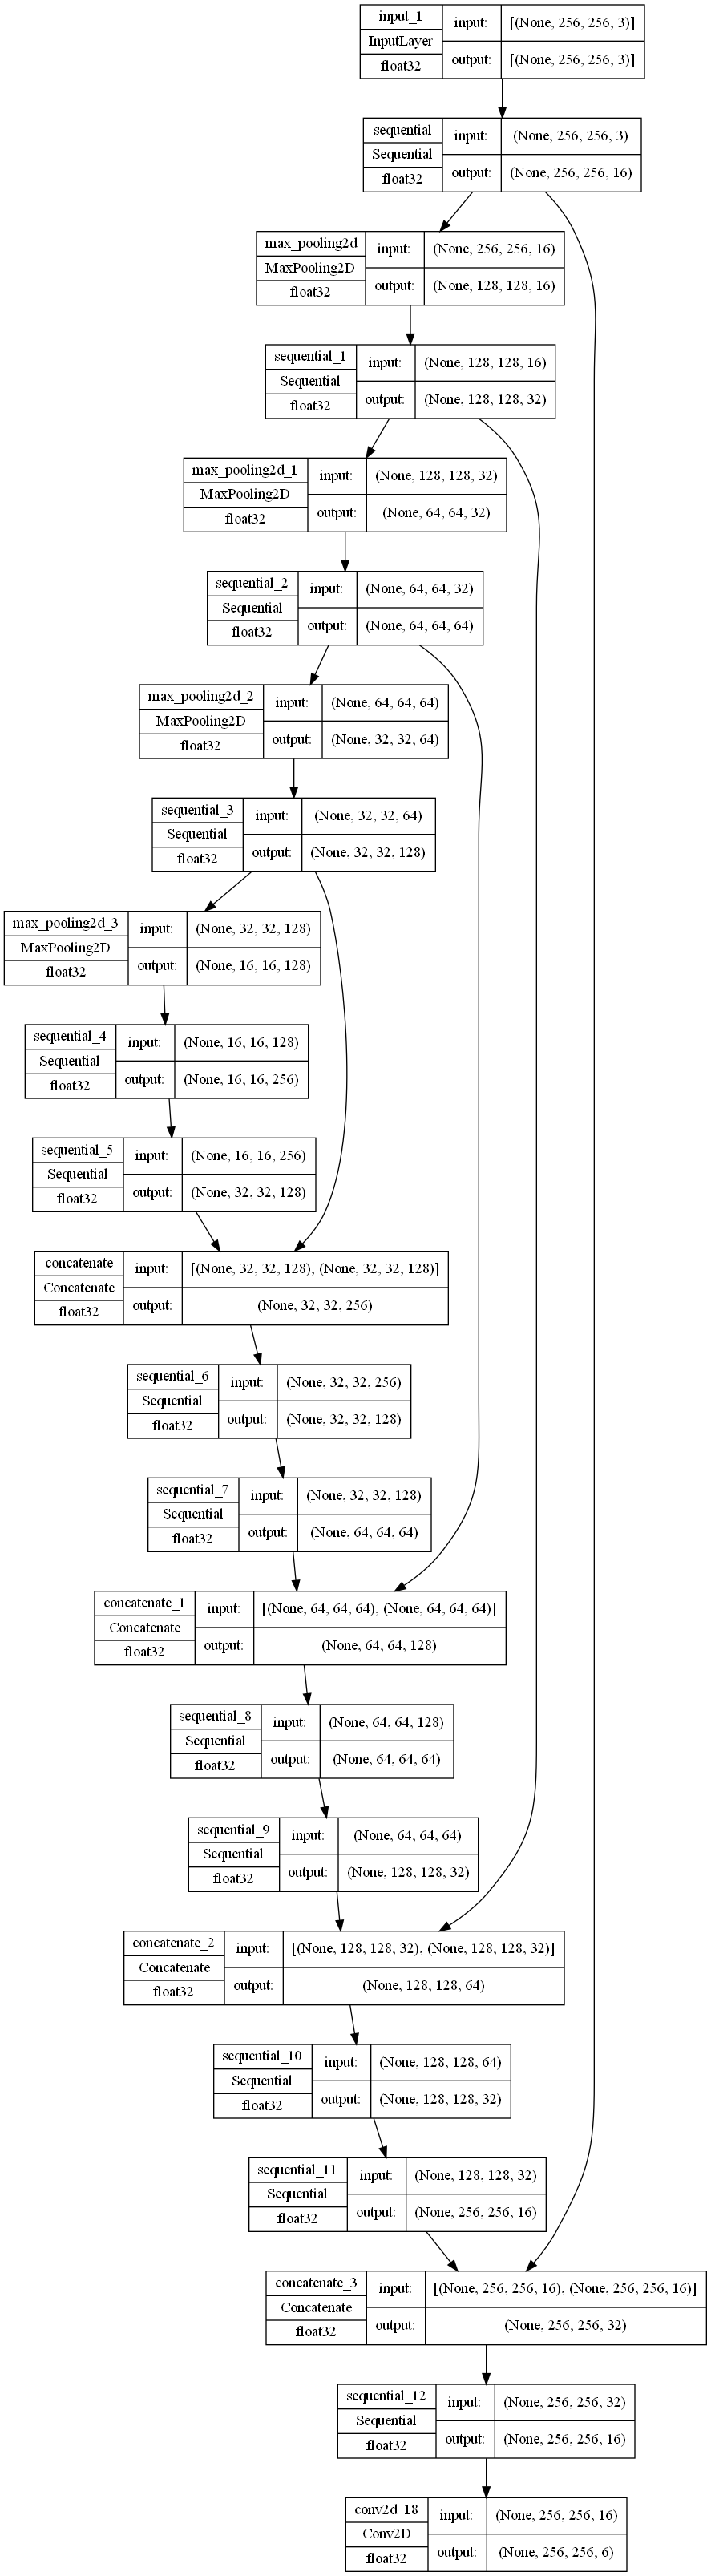

In [23]:
keras.utils.plot_model(model, show_shapes=True, show_dtype=True, expand_nested=False)

In [24]:
def iou(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [25]:
weights = [0.166, 0.166, 0.166, 0.166, 0.166, 0.166]
diceloss = sm.losses.DiceLoss(class_weights=weights)
focalloss = sm.losses.CategoricalFocalLoss()
total_loss = diceloss + (1 * focalloss)

In [34]:
model.compile(loss=total_loss,
            optimizer='adam',
            metrics=['accuracy', iou])

In [35]:
history = model.fit(train_ds, epochs=100, validation_data=val_ds)

Epoch 1/100
17/66 [======>.......................] - ETA: 14:20 - loss: 0.2277 - accuracy: 0.2906 - iou: 0.2029

KeyboardInterrupt: 